In [1]:
# Execute if necessary
# %%capture
# !pip install numpy seaborn matplotlib pandas openml

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from typing import Dict, Tuple, Union, List
import openml
import sklearn
np.random.seed(42)

# Práctica 6: Máquinas de Vectores de Soporte

__Instrucciones__: A continuación hay una lista de funciones que debe implementar o tareas que debe desarrollar. La descripción de cada una de ellas se encuentra en la definición de cada una de las funciones.

La entrega de la práctica será en la siguiente sesión a menos que la indicación sea otra. La revisión iniciará al iniciar la sesión y únicamente podrá ser evaluada durante la duración de la sesión.

## Asignación 1

Genera un dataset de clasificación binaria $\pm1$, de veinte instancias, aleatorio, de dos características, que sea linealmente separable. Grafique el dataset generado y coloree los puntos deacuerdo a su etiqueta.

In [ ]:
def generate_data(
    n_dims: int=2,
    n_samples: int=20,
    distribution: str = 'uniform',
    parametros: dict[str, float] = {'low': 0, 'high': 20}
) -> np.array:
    """
    Descripción:
    Esta funcion genera datos artificiales muestreados de una distribución de probabilidad especificada.
    
    Entradas:
    - n_dims: Número de dimensiones (características) que contendrá cada ejemplo 
    - n_samples: Número de muestreos (ejemplos) que deberán ser generados
    - from_distribution: Distribución de la que deberán ser muestreados los puntos, "normal" o "uniform"   
    - distribution_params: Parámetros para la distribución de la que serán muestradas los valores.
        "uniform": {
            "low": El número mínimo que puede ser muestreado
            "high": El número máximo que puede ser muestreado
            }
        "normal": {
            "mean": La media que tendrá la distribución normal
            "std": La desviación estándar de la distribución normal
            }
            
    Salidas:
    - Un arreglo de numpys muestreado de la distribución seleccionada con dimensiones (n_samples, n_dims)
    """
    # examples = np.random((n_samples, n_dims))
    np.random.seed(1509345)

    # CÓDIGO AQUÍ

    if distribution == "uniform":
        low = parametros.get("low", 0)
        high = parametros.get("high", 1)
        examples = np.random.uniform(low, high, size=(n_samples, n_dims))

    elif distribution == "normal":
        mean = parametros.get("mean", 0)
        std = parametros.get("std", 1)
        examples = np.random.normal(mean, std, size=(n_samples, n_dims))

    return examples


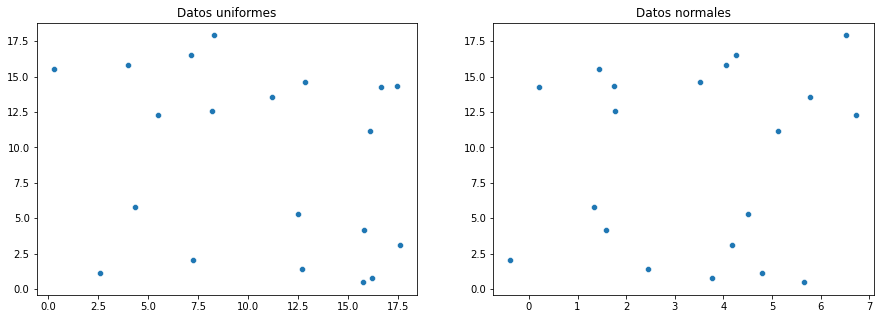

In [ ]:
uniform = generate_data()

normal = generate_data(
    distribution="normal", 
    parametros={"mean": 3., "std": 2.}
)

fig, axs = plt.subplots(ncols= 2, figsize =(15,5))
axs[0].set_title('Datos uniformes')
axs[1].set_title('Datos normales')
a = sns.scatterplot(x = uniform[:, 0], y= uniform[:, 1], ax=axs[0])
b = sns.scatterplot(x=normal[:, 0], y=uniform[:,1], ax=axs[1])

In [ ]:
def label_data(
    data: np.array,
    model: np.array = None
) -> np.array:
    """
    Descripción:
    Esta funcion genera el etiquetado de datos artificiales de acuerdo a un modelo generado. 
    En caso de no ser recibido como parámetro, el modelo debe ser generado aleatoriamente de 
    una distribución normal con media 0 y varianza 1.
    
    Entradas:
    - data: Datos a etiquetar de dimensiones Número de dimensiones (# ejemplos, # características)
    - model: Modelo utilizado para etiquetar
            
    Salidas:
    - Un arreglo de numpy referente a las etiquetas asignadas a cada ejemplo recibido en la entrada "data".
    - Un arreglo de numpy referente al modelo generado aleatoriamente.
    """

    labels = np.zeros((data.shape[0],))
    # if model is None:
    #     model = __random_fn__((data.shape[1] + 1,))

    # CÓDIGO AQUÍ
    if model is None:
        np.random.seed(1509345)
        model = np.random.normal(
            loc=0,
            scale=1,
            size=data.shape[1] + 1
        )

    data = np.concatenate((np.ones((data.shape[0], 1)), data), axis=1)

    predictions = np.tanh(np.dot(data, model))
    labels[predictions >= 0] = 1
    labels[predictions < 0] = -1

    return labels, model


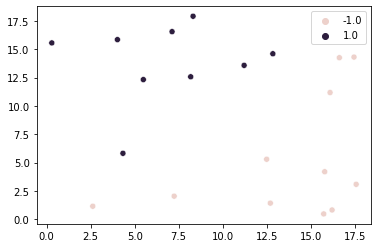

In [ ]:
__labels__, __model__ = label_data(uniform)

assert __labels__.shape == (20,)
assert __model__.shape == (2 + 1,)

_ = sns.scatterplot(x=uniform[:, 0], y=uniform[:, 1], hue=__labels__)


In [ ]:
def simplified_smo(
    C: float, tol: float, X: np.array, y: np.array, max_passes: int = 100
) -> np.array:
    """Algoritmo de Support Vector Machine simplificado.

    Args:
        C (float): Parametro de regularización (0.1, 1, 10, 100, etc.)
        tol (float): Valor de tolerancia (0.001, 0.0001)
        X (np.array): valores que queremos separar
        y (np.array): Etiqueta de los valores de x
        max_passes (int, optional): Número de veces que repite el algoritmo. Defaults to 100.

    Returns:
        alpha : valores de lagrange que es la solucion
        b : Umbral para la solución o intersección entre datos
    """
    # Inicializamos m, n para no hacerlo despues
    m, n = X.shape
    # Creamos un arreglo donde se almacenan los valores de alpha
    alpha = np.zeros(m)
    b = 0
    passes = 0

    while passes < max_passes:
        num_changed_alphas = 0
        for i in range(m):
            # Calculo del ei y el kernel al mismo tiempo usando el producto punto
            E_i = np.dot(alpha * y, np.dot(X, X[i])) + b - y[i]
            # Verificamos la condición de KKT (Kernel Karush-Kuhn-Tucker)
            if (y[i] * E_i < -tol and alpha[i] < C) or (
                y[i] * E_i > tol and alpha[i] > 0
            ):
                # Generamos un indice aleatorio
                j = np.random.choice(np.delete(np.arange(m), i))
                # calculamos el e_j
                E_j = np.dot(alpha * y, np.dot(X, X[j])) + b - y[j]
                # guardamos el valor antiguo de los alpha
                alpha_i_old, alpha_j_old = alpha[i], alpha[j]
                # Calcular los límites de alpha[j] para que satisfagan las restricciones
                if y[i] != y[j]:
                    L = max(0, alpha[j] - alpha[i])
                    H = min(C, C + alpha[j] - alpha[i])
                else:
                    L = max(0, alpha[i] + alpha[j] - C)
                    H = min(C, alpha[i] + alpha[j])
                # Si L = H, no se puede hacer nada
                if L == H:
                    continue
                # Calcular el valor no restringido de alpha[j]
                eta = 2 * np.dot(X[i], X[j]) - np.dot(X[i], X[i]) - np.dot(X[j], X[j])
                if eta >= 0:
                    continue
                # Calcular y recortar el nuevo valor de alpha[j]
                alpha[j] = alpha[j] - (y[j] * (E_i - E_j)) / eta
                alpha[j] = np.clip(alpha[j], L, H)
                # Calcular los valores de b para los nuevos valores de alpha[i] y alpha[j]
                if abs(alpha[j] - alpha_j_old) < 1e-5:
                    continue
                alpha[i] = alpha[i] + y[i] * y[j] * (alpha_j_old - alpha[j])
                b_i = (
                    b
                    - E_i
                    - y[i] * (alpha[i] - alpha_i_old) * np.dot(X[i], X[i])
                    - y[j] * (alpha[j] - alpha_j_old) * np.dot(X[i], X[j])
                )
                b_j = (
                    b
                    - E_j
                    - y[i] * (alpha[i] - alpha_i_old) * np.dot(X[i], X[j])
                    - y[j] * (alpha[j] - alpha_j_old) * np.dot(X[j], X[j])
                )
                if 0 < alpha[i] < C:
                    b = b_i
                elif 0 < alpha[j] < C:
                    b = b_j
                else:
                    b = (b_i + b_j) / 2
                num_changed_alphas += 1
        # Si no se hacen cambios en el ciclo, salimos del while
        # Si no, aumentamos el contador de pasos
        if num_changed_alphas == 0:
            passes += 1
        else:
            passes = 0
    return alpha, b


In [ ]:
# def simplified_smo(C : float, tol: float, x : np.array, y : np.array, max_pasos=100) :
#     """Algoritmo de Support Vector Machine simplificado.

#     Args:
#         C (float): Parametro de regularización (0.1, 1, 10, 100, etc.)
#         tol (float): Valor de tolerancia (0.001, 0.0001)
#         X (np.array): valores que queremos separar
#         y (np.array): Etiqueta de los valores de x
#         max_passes (int, optional): Número de veces que repite el algoritmo. Defaults to 100.

#     Returns:
#         alpha : valores de lagrange que es la solucion
#         b : Umbral para la solución o intersección entre datos
#     """    
#     # Inicialización de alphas
#     alpha = np.zeros(x.shape[0])
#     b = 0
#     pasos = 0
#     # max_pasos = 1000
#     # Inicializamos m, n para no hacerlo despues
#     m, n = x.shape
#     # Cálculo del kernel usando el producto punto
#     kernel = np.dot(x, x.T)
#     # Lista para guardar los alphas antiguos
#     old_alpha = np.zeros(x.shape[0])
#     alpha_j = 0

#     while pasos < max_pasos:
#         num_changed_alphas = 0
#         for i in range(len(x)):
#             # Calcule Ei usando la fórmula correcta
#             Ei = np.sum(alpha * y * kernel[i]) + b - y[i]

#             # Verificamos la condición de KKT (Kernel Karush-Kuhn-Tucker)
#             if (Ei * y[i] < -tol and alpha[i] < C) or (
#                 Ei * y[i] > tol and alpha[i] > 0
#             ):
#                 # Generamos un indice aleatorio
#                 j = np.random.choice(np.delete(np.arange(m), i))

#                 # Calcule Ej 
#                 Ej = np.sum(alpha * y * kernel[j]) + b - y[j]

#                 # Salvar el valor antiguo de alpha[j]
#                 alpha_j_old = alpha[j]

#                 # Calcular los límites de alpha[j] para que satisfagan las restricciones
#                 if y[i] != y[j]:
#                     L = max(0, alpha[j] - alpha[i])
#                     H = min(C, C + alpha[j] - alpha[i])
#                 else:
#                     L = max(0, alpha[j] + alpha[i] - C)
#                     H = min(C, alpha[j] + alpha[i])

#                 # Si L = H, no se puede hacer nada
#                 if L == H:
#                     continue

#                 # Calcular el valor no restringido de alpha[j]
#                 # fórmula tomada del documento original CS 229, Autumn 2009
#                 eta = 2 * kernel[i][j] - kernel[i][i] - kernel[j][j]
#                 if eta >= 0:
#                     continue

#                 # Calcular y recortar el nuevo valor de alpha[j]
#                 alpha[j] = alpha[j] - (y[j] * (Ei - Ej)) / eta
#                 alpha[j] = max(alpha[j], L)
#                 alpha[j] = min(alpha[j], H)

#                 # Revisar si hay cambios suficientemente grandes en alpha[j]
#                 if abs(alpha[j] - alpha_j_old) < 1e-5:
#                     continue

#                 # Calcular el valor correspondiente de alpha[i]
#                 alpha[i] = alpha[i] + y[i] * y[j] * (alpha_j_old - alpha[j])

#                 # Calcular los valores de b para los nuevos valores de alpha[i] y alpha[j]
#                 bi = (
#                     b
#                     - Ei
#                     - y[i] * (alpha[i] - alpha_j_old) * kernel[i][i]
#                     - y[j] * (alpha[j] - alpha_j_old) * kernel[i][j]
#                 )
#                 bj = (
#                     b
#                     - Ej
#                     - y[i] * (alpha[i] - alpha_j_old) * kernel[i][j]
#                     - y[j] * (alpha[j] - alpha_j_old) * kernel[j][j]
#                 )
#                 if alpha[i] > 0 and alpha[i] < C:
#                     b = bi
#                 elif alpha[j] > 0 and alpha[j] < C:
#                     b = bj
#                 else:
#                     b = (bi + bj) / 2

#                 num_changed_alphas += 1

#         # Si no se hacen cambios en el ciclo, salimos del while
#         if num_changed_alphas == 0:
#             break

#         # Si no, aumentamos el contador de pasos
#         pasos += 1

#     return alpha, b

In [ ]:
alpha, b = simplified_smo(10, 0.0001, uniform, __labels__, 1000)

In [ ]:
def plot_separating_hyperplane(
    alpha: np.array, x: np.array, y: np.array, b: float
) -> None:
    """Función para graficar los puntos y el hiperplano que separa dicho puntos

    Args:
        alpha (np.array): valores de alpha optimizados
        x (np.array): valores que queremos separar
        y (np.array): etiquetas de los valores
        b (float): valor de interseccion del hiperplano
    """
    # Calcular la pendiente de la recta
    uniform = np.tile(alpha * y, (x.shape[1], 1)).T * x
    w = np.sum(uniform, axis=0)

    # plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k")
    # # Graficar los vectores de soporte
    # plt.scatter(
    #     x[alpha > 1e-6, 0], x[alpha > 1e-6, 1], s=150, facecolors="none", edgecolors="k"
    # )

    # Graficar la recta
    xp = np.linspace(np.min(x[:, 0]), np.max(x[:, 0]), 100)
    yp = -(w[0] * xp + b) / w[1]
    plt.plot(xp, yp, "k-")
    plt.scatter(x[:, 0], x[:, 1], c=y, cmap=plt.cm.Paired, edgecolors="k", label='Datos')
    plt.scatter(x[alpha > 1e-6, 0], x[alpha > 1e-6, 1], s=150, facecolors="none", edgecolors="k", label='Vectores de soporte')
    plt.plot(xp, yp, "k-", label='Línea de separación')
    plt.legend(bbox_to_anchor =(0.90, 1.0), ncol = 1)
    plt.title('Valores separados por el hiperplano')
    
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    # plt.axis("tight")
    plt.show()

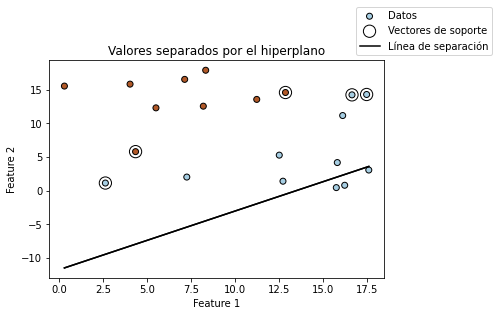

In [ ]:
plot_separating_hyperplane(alpha, uniform, __labels__, b)

## Asignación 2

Genera un dataset de clasificación binaria $\pm1$, de veinte instancias, aleatorio, de dos características, que contenga todos los puntos de una clase entre dos parábolas y los puntos por arriba o por debajo de estas parábolas pertenezcan a la otra clase. Grafique el dataset generado y coloree los puntos deacuerdo a su etiqueta.

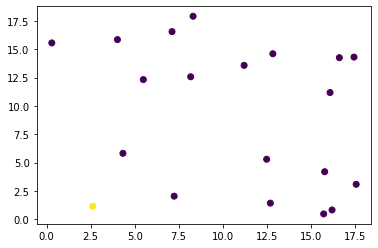

In [ ]:
def parabola(x1, x2):
    y1 = -0.2 * x1**2 + 4
    y2 = 0.2 * x1**2 - 4
    if x2 < y1 and x2 > y2:
        return 1
    else:
        return -1


# Generar un conjunto de datos aleatorio de 20 instancias con dos características
# np.random.seed(0)
X = generate_data()

# Clasificar los puntos en dos clases
y = np.zeros(20)
for i in range(20):
    y[i] = parabola(X[i, 0], X[i, 1])

# Crear un gráfico de dispersión que muestre los puntos y su etiqueta
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.show()

In [ ]:
alpha_parab, b_parab = simplified_smo(0.01, 0.0001, X, y, 100)

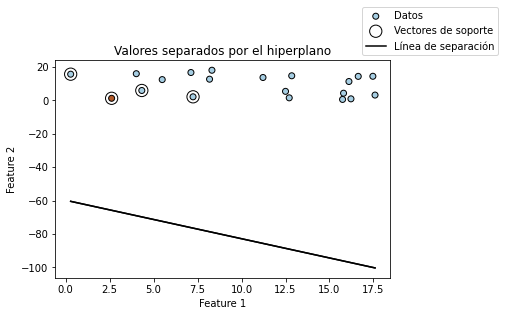

In [ ]:
plot_separating_hyperplane(alpha_parab, X, y, b_parab)

## Asignación 3

Implemente una clase que permita ajustar un modelo de Máquinas de Vectores de Soporte. La clase debe cumplir con los siguientes requisitos:

- Debe contar con un método para realizar el entrenamiento en caso de ser requerido.
- Debe contar con un método para realizar las predicciones.
- Debe de poder utilizar un kernel de identidad o de RBF.
- Debe almacenar los vectores de soporte.

## Asignación 4

Entrene un modelo de SVM (utilizando la clase implementada anteriormente) utilizando el dataset generado en la asignación 1 y un kernel de identidad. Grafique las predicciones de su modelo y marque los puntos que son vectores de soporte.

## Asignación 5

Entrene un modelo de SVM (utilizando la clase implementada anteriormente) utilizando el dataset generado en la asignación 2 y un kernel de RBF. Grafique las predicciones de su modelo y marque los puntos que son vectores de soporte.